# Neural Network Database API Intro

## Overview

This is a quick intro to using the Neural Network Database API. First we will set up an API client and then retrieve all the networks to analyze the relationship between optimizers and loss functions. Then we will look at more fine-grained queries such as retrieving networks used for image generation.

Prerequisites:
- Python 3.5 or later
- The `aughie` and `matplotlib` packages. 

You can also run this notebook online directly from your browser by following the link to [Google Colab.](https://colab.research.google.com/github/aughie/aughie-py/blob/master/docs/examples/nndb_api.ipynb) 

As a word of caution, the project is currently in a proof-of-concept phase and the dataset is too small to be representative. With that in mind, let's jump in!

## Setting up the client

First we install the required packages, then we import them. The `aughie` package contains the neural network database client and we will use  `matplotlib` to make visualizations from the retrieved data.


In [1]:
# If you run this in Google Colab, there might be warnings about conflicting 
# versions with their implicit environment, but it can be safely ignored.
!pip install aughie matplotlib==2.2.3 > /dev/null

In [2]:
from aughie import nndb

# Allow matplotlib plots to be displayed in the notebook.
%matplotlib inline

Next we create a client to communicate with the neural network database API. The client has an in-memory cache so we can rerun cells over and over again without having to make a new request every time.

In [3]:
client = nndb.ApiClient()

## Analyzing optimizers and loss functions

Let's retrieve all the networks to see how optimizers and loss functions are related to each other. The API calls return `ApiResult` objects that have methods to present the data in different formats.

In [4]:
networks = client.get_networks()

networks_list = networks.to_list()
num_networks = len(networks_list)
print('There are currently {} networks in the database.'.format(num_networks))
print('The first two results are printed below:')
networks_list[:2]

There are currently 46 networks in the database.
The first two results are printed below:


[{'losses': [{'type': 'mse'}],
  'name': 'eriklindernoren/Keras-GAN/lsgan',
  'numInputs': 1,
  'numLayers': 20,
  'numOutputs': 1,
  'optimizer': {'hasDecay': False,
   'learningRate': 0.00019999999494757503,
   'type': 'Adam'}},
 {'losses': [{'type': 'categorical_crossentropy'}],
  'name': 'basveeling/wavenet/wavenet',
  'numInputs': 1,
  'numLayers': 66,
  'numOutputs': 1,
  'optimizer': {'hasDecay': False,
   'learningRate': 0.0010000000474974513,
   'type': 'SGD'}}]

Let's turn this into a Pandas DataFrame so we can work with the data more easily. We can specify the columns that we want included in the data frame with the `fields` argument. Finally, we display 10 randomly selected rows from the data. 

In [5]:
fields = ['name', 'numLayers', 'optimizer', 'learningRate', 'loss']
df = networks.to_data_frame(fields=fields)
df.sample(10, random_state=0).sort_index()

,name,numLayers,optimizer,learningRate,loss
26,farizrahman4u/seq2seq/AdvancedSeq2Seq,8,RMSprop,0.0010,mse
29,farizrahman4u/seq2seq/PeakySeq2Seq,8,RMSprop,0.0010,mse
31,farizrahman4u/seq2seq/DeepSeq2Seq_v2,21,RMSprop,0.0010,mse
33,keras-team/keras-applications/NASNet,751,NaN,NaN,NaN
34,keras-team/keras-applications/xception,134,NaN,NaN,NaN
40,keras-rl/keras-rl/naf_pendulum_l_model,12,NaN,NaN,NaN
43,keras-rl/keras-rl/sarsa_cartpole,9,NaN,NaN,NaN
45,keras-rl/keras-rl/ddpg_pendulum_actor,9,SGD,0.0100,mse
61,eriklindernoren/Keras-GAN/ccgan,39,Adam,0.0002,mse
62,eriklindernoren/Keras-GAN/cgan,33,Adam,0.0002,binary_crossentropy


The `name` of a network is made up of three parts: the Github user name of the author, the Github repo name and a descriptive name for the network. The `NaN` values indicate missing data.

Let's see what optimizers are used with different losses and their relative frequencies:

In [6]:
df.groupby('loss')['optimizer'].value_counts(True)

loss                             optimizer
MultiboxLoss                     Adam         1.000000
binary_crossentropy              Adam         1.000000
categorical_crossentropy         Adam         0.500000
                                 SGD          0.500000
mae                              Adam         1.000000
mse                              Adam         0.500000
                                 RMSprop      0.272727
                                 SGD          0.227273
sparse_categorical_crossentropy  Adam         1.000000
Name: optimizer, dtype: float64

What are the typical learning rates for the different optimizers?

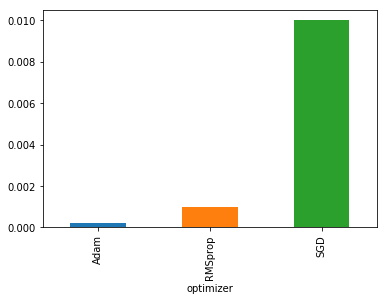

In [7]:
# pandas is a dependency of aughie, so we don't have to install it separately.
import pandas as pd
df.groupby('optimizer')['learningRate'].agg(pd.Series.mode).plot.bar()

## Applying multiple filters

Now let's get a little more specific. What if we were interested in networks used for image generation? These will likely contain both `Conv2D` and `UpSampling2D` layers, so let's make a query looking for networks that have these two types of layers. 

In [8]:
layers = [{'type': 'Conv2D'}, {'type': 'UpSampling2D'}]
gen_networks = client.get_networks(layers=layers)
fields = ['name', 'numLayers', 'numOutputs', 'optimizer', 'learningRate', 'loss']
gen_networks.to_data_frame(fields=fields)

,name,numLayers,numOutputs,optimizer,learningRate,loss
0,eriklindernoren/Keras-GAN/discogan,122,6,Adam,0.0002,mae
1,eriklindernoren/Keras-GAN/discogan,122,6,Adam,0.0002,mae
2,eriklindernoren/Keras-GAN/discogan,122,6,Adam,0.0002,mae
3,eriklindernoren/Keras-GAN/discogan,122,6,Adam,0.0002,mse
4,eriklindernoren/Keras-GAN/discogan,122,6,Adam,0.0002,mse
5,eriklindernoren/Keras-GAN/discogan,122,6,Adam,0.0002,mae
6,eriklindernoren/Keras-GAN/context_encoder,36,2,Adam,0.0002,mse
7,eriklindernoren/Keras-GAN/context_encoder,36,2,Adam,0.0002,binary_crossentropy
8,eriklindernoren/Keras-GAN/dcgan,33,1,Adam,0.0002,binary_crossentropy
9,eriklindernoren/Keras-GAN/pix2pix,63,2,Adam,0.0002,mse


If a network has multiple loss functions, it will be added in multiple rows. For the GAN networks, the combined models are included in the dataset, that's why they have so many outputs.

We can build even more complex queries by combining different filters. The following query will return networks that
* have a minimum of 100 layers and 2 outputs and
* use binary or categorical cross entropy loss and
* have at least one Conv2D layer with a tanh activation and at least one MaxPooling2D layer.

In [9]:
networks = client.get_networks(network={'minNumLayers': 100, 'minNumOutputs': 2},
                               losses=[{'type': 'binary_crossentropy'},
                                       {'type': 'categorical_crossentropy'}],
                               layers=[{'type': 'Conv2D', 'activation': 'tanh'},
                                       {'type': 'MaxPooling2D'}])
fields = ['name', 'numLayers', 'numOutputs', 'optimizer', 'learningRate', 'loss']
networks.to_data_frame(fields=fields)

,name,numLayers,numOutputs,optimizer,learningRate,loss
0,eriklindernoren/Keras-GAN/srgan,164,2,Adam,0.0002,binary_crossentropy
1,eriklindernoren/Keras-GAN/srgan,164,2,Adam,0.0002,mse


## Next steps

Check out the [documentation](https://aughie-py.readthedocs.io) or open an issue in the [aughie-py repository](https://github.com/aughie/aughie-py) to provide feedback.